# Breast Cancer Classifier

Using the Breast cancer wisconsin (diagnostic) dataset, I will train a K-means classifier to predict weather a patient has breast cancer.

## 1. Import the data from sklearn datasets and libraries needed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.datasets import load_breast_cancer

breast_cancer_data = load_breast_cancer()

## 2. EDA

## 2.1 How many samples are there?
Each sample is either malignant (0) or benign (1).\
These sample identifications can be found under the 'target' key





In [3]:
# benign samples are represented by a 1 so summing the array will give a count
number_of_benign = sum(breast_cancer_data['target'])

# number of malignant samples is total - number_of_benign
number_of_malignant = len(breast_cancer_data['target']) - number_of_benign

print("Number of benign samples: {benign}".format(benign = number_of_benign))
print("Number of malignant samples: {malignant}".format(malignant = number_of_malignant))
print("Total number of samples: ",len(breast_cancer_data['target']))


Number of benign samples: 357
Number of malignant samples: 212
Total number of samples:  569


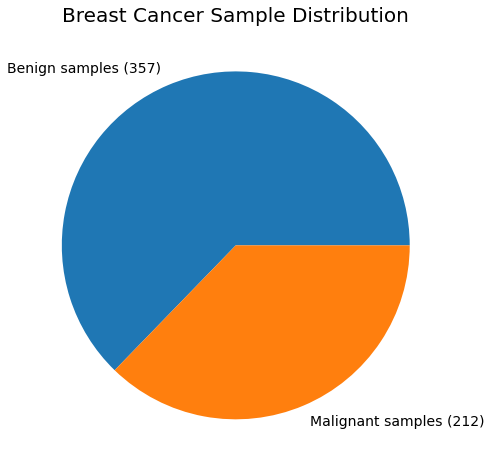

In [4]:
plt.figure(figsize=(8, 8))
plt.pie([number_of_benign,number_of_malignant],labels =['Benign samples (357)',"Malignant samples (212)"],textprops={'fontsize': 14})
plt.title("Breast Cancer Sample Distribution",size=20)
plt.show() 

## 2.2 Check for missing values
No missing data points

In [5]:
(sum(pd.isnull(breast_cancer_data['data'])))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

## 2.2 What features are there?
There are 10 core features for each sample from mean radius to symmetry.

Accomlying the standard mean values there are also error and 'worst' values.

Leading to 30 total features.

In [6]:
print(breast_cancer_data['feature_names'])

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [7]:
# Create a pandas dataframe for easier analysis of the features
feature_dataframe = pd.DataFrame(breast_cancer_data['data'], columns = breast_cancer_data['feature_names'])

No surprises that features such as radius, parimeter and area are highly correlated with each other being functionally related.

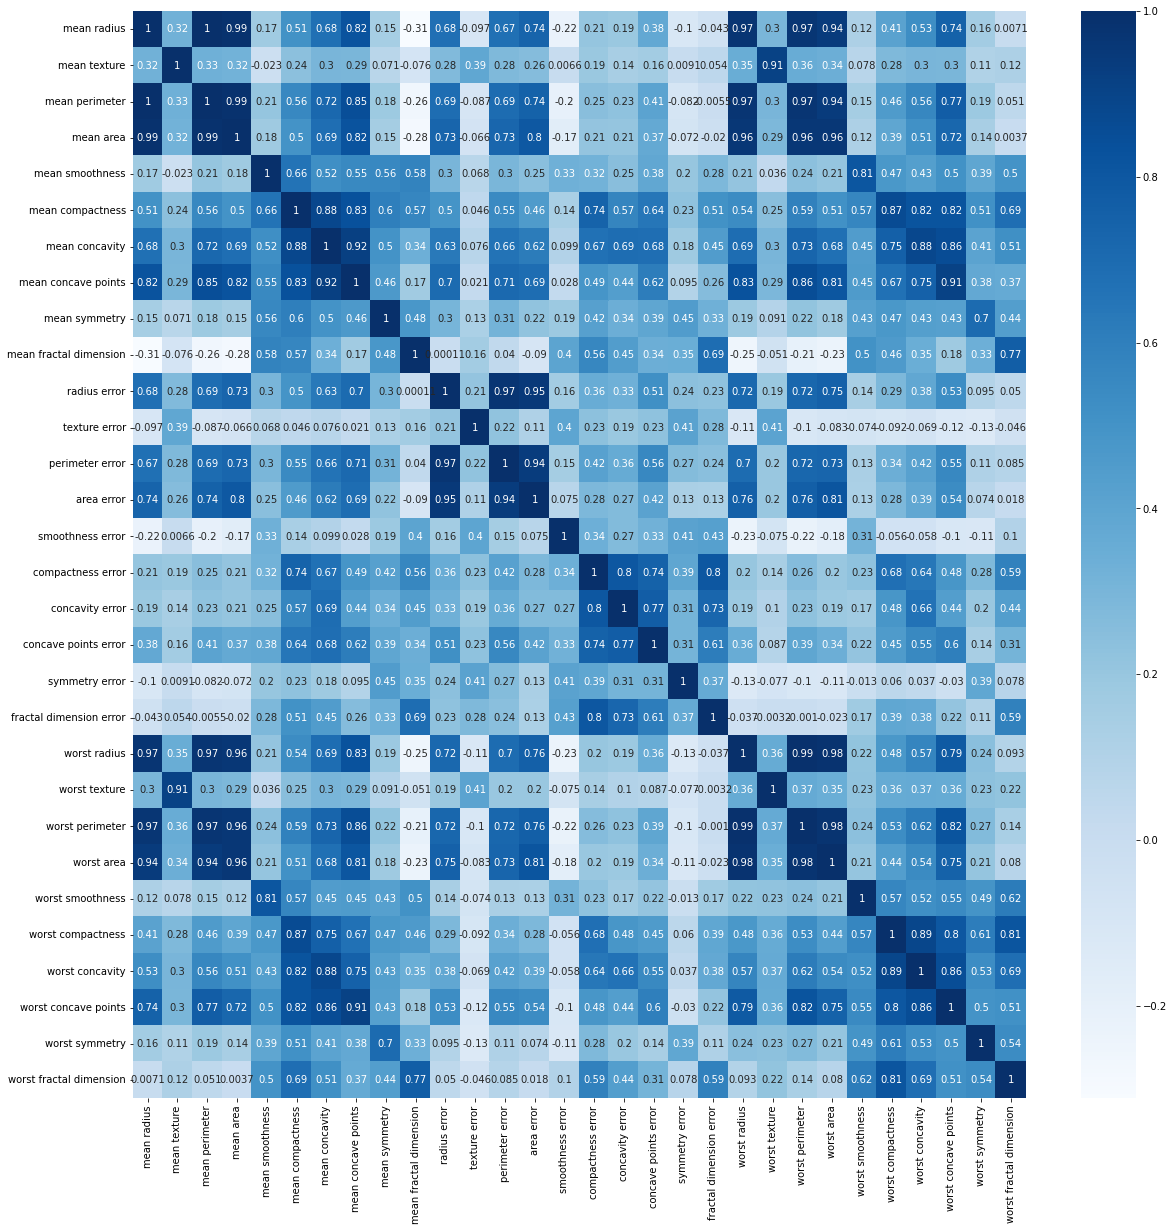

In [8]:
# plot correlation heat map
plt.figure(figsize=(20,20))
sns.heatmap(feature_dataframe.corr(),cbar=True,annot=True,cmap='Blues')

## 2.3 Principle Component Analysis

In order for K-means to be deployed we must first see if the samples can be clustered visually from PCA analysis - if this is not possible it is unlikely K-means will work 

### 2.3.1 2D PCA

In [9]:
# PCA is effected by the scale of the data so transform the data first
from sklearn.preprocessing import StandardScaler

transformed = StandardScaler().fit_transform(feature_dataframe)
transformed=pd.DataFrame(transformed,columns=breast_cancer_data['feature_names'])

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(transformed)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf['target'] = breast_cancer_data['target']

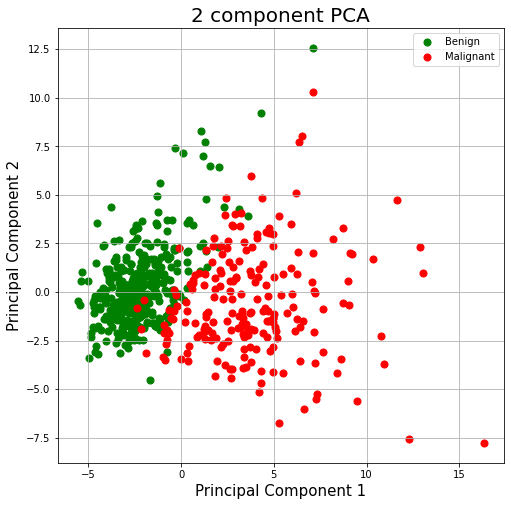

In [11]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(['Benign', 'Malignant'])
ax.grid()

There is some overlap between Benign and malignant samplesin PCA but there is two clear clusters. Therefor K-means should work

### 2.3.2 How many PCA components are required to obtain 95% of the variance?

In [12]:
from sklearn.decomposition import PCA
pca = PCA(.95)
principalComponents = pca.fit_transform(transformed)
principalDf = pd.DataFrame(data = principalComponents)

principalDf['target'] = breast_cancer_data['target']
print("Number of PCA components to obtain 95% of the variance: ",pca.n_components_ )

Number of PCA components to obtain 95% of the variance:  10


In [13]:
n_pcs= pca.components_.shape[0]

In [14]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

In [15]:
initial_feature_names = breast_cancer_data['feature_names']

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

df = pd.DataFrame(dic.items())

df

,0,1
0,PC0,mean concave points
1,PC1,mean fractal dimension
2,PC2,texture error
3,PC3,worst texture
4,PC4,mean smoothness
5,PC5,worst symmetry
6,PC6,worst fractal dimension
7,PC7,smoothness error
8,PC8,concavity error
9,PC9,mean symmetry


These are the features that account for 95% of the variability of the dataset - not strictly the most important 10 features. We will revisit this when we come to training the model - extracting these features can decrease the amount of time it takes to train a model with minimal impact on the accuracy. It is unlikely we will see a drastic decrease in model training for this senario though as there is only a small amount of samples and features

## 3. K-means training and prediction

## 3.1 Full dataset

### 3.1.1 Extract Validation set

This protects from overfitting of the training data

In [43]:
from sklearn.model_selection import train_test_split



training_data, validation_data, training_labels, validation_labels = train_test_split(breast_cancer_data.data, breast_cancer_data.target, test_size = 0.2, random_state = 120)

print(len(training_data), len(training_labels))

455 455


### 3.1.2 Find the best K for the classifier

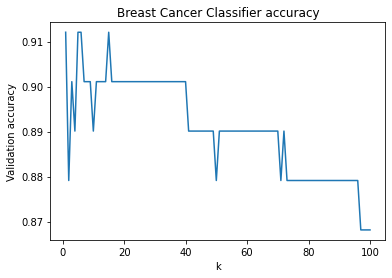

--- 7.538253307342529 seconds ---


In [44]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import time
start_time = time.time()



k_list = []
accuracies = []
for k in range (1, 101):
    k_mean = []
    for i in range(1,11):
        train_data, test_data, train_labels, test_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state = 120)
        classifier = KNeighborsClassifier(n_neighbors = k)
        classifier.fit(train_data, train_labels)
        k_mean.append(classifier.score(test_data, test_labels))
    k_list.append(k)
    accuracies.append(np.mean(k_mean))
    
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("Breast Cancer Classifier accuracy")
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [46]:
pd.DataFrame.from_dict({'K':k_list, 'accuracy':accuracies}).sort_values('accuracy', ascending=False).head(5)

,K,accuracy
0,1,0.912088
4,5,0.912088
5,6,0.912088
14,15,0.912088
31,32,0.901099


### 3.1.3 Validate which K is the best using the validation set

Training and testing for different values of K identified 1, 5, 6 and 15 as the best. Now to use the validation set we with held to test which is the best.

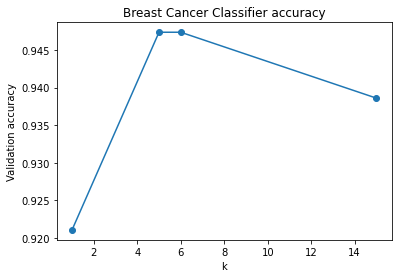

In [38]:
k_values = [1,5,6,15]
res = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(training_data, training_labels)

    res.append(classifier.score(validation_data, validation_labels))

plt.plot(k_values, res,marker='o')
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("Breast Cancer Classifier accuracy")
plt.show()

#### 3.1.4 Normalising before training and testing

K-means like PCA is effected by different features being in different scales to reduce this we should normalise the data before training and testing. Doing this we see a significant increase in accuracy

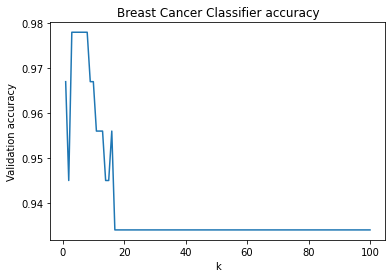

--- 7.560214281082153 seconds ---


In [55]:
training_data, validation_data, training_labels, validation_labels = train_test_split(StandardScaler().fit_transform(breast_cancer_data.data), breast_cancer_data.target, test_size = 0.2, random_state = 120)

start_time = time.time()



k_list = []
accuracies = []
for k in range (1, 101):
    k_mean = []
    for i in range(1,11):
        train_data, test_data, train_labels, test_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state = 120)
        classifier = KNeighborsClassifier(n_neighbors = k)
        classifier.fit(train_data, train_labels)
        k_mean.append(classifier.score(test_data, test_labels))
    k_list.append(k)
    accuracies.append(np.mean(k_mean))
    
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("Breast Cancer Classifier accuracy")
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

#### 3.1.4 Normalising before training and testing - validate k

The K's with the highest accuracy are 3-8

In [56]:
pd.DataFrame.from_dict({'K':k_list, 'accuracy':accuracies}).sort_values('accuracy', ascending=False).head(6)

,K,accuracy
2,3,0.978022
3,4,0.978022
4,5,0.978022
5,6,0.978022
6,7,0.978022
7,8,0.978022


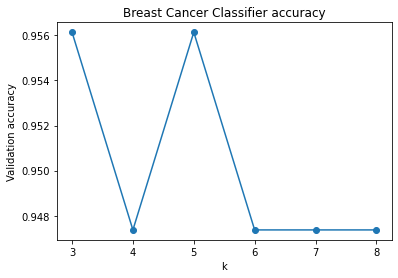

In [57]:
k_values = [3,4,5,6,7,8]
res = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(training_data, training_labels)

    res.append(classifier.score(validation_data, validation_labels))

plt.plot(k_values, res,marker='o')
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("Breast Cancer Classifier accuracy")
plt.show()

### 3.2 Using 95% variance dataset

Using the 10 features we Identified earlier using PCA to maintain 95% of the variance we want to see if there is any different in performance

In [60]:
df[1].tolist()

['mean concave points',
 'mean fractal dimension',
 'texture error',
 'worst texture',
 'mean smoothness',
 'worst symmetry',
 'worst fractal dimension',
 'smoothness error',
 'concavity error',
 'mean symmetry']

In [72]:
feature_index = []

for x in df[1].tolist():
    feature_index.append((np.where(breast_cancer_data['feature_names'] == x)[0][0]))
feature_index

[7, 9, 11, 21, 4, 28, 29, 14, 16, 8]

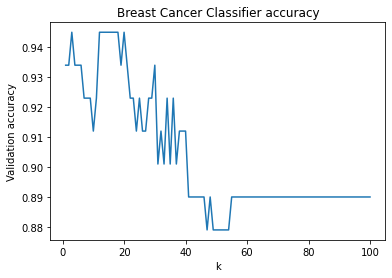

--- 6.074412107467651 seconds ---


In [78]:
from sklearn.model_selection import train_test_split

training_data, validation_data, training_labels, validation_labels = train_test_split(StandardScaler().fit_transform(breast_cancer_data.data[:,feature_index]), breast_cancer_data.target, test_size = 0.2, random_state = 120)


import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import time
start_time = time.time()



k_list = []
accuracies = []
for k in range (1, 101):
    k_mean = []
    for i in range(1,11):
        train_data, test_data, train_labels, test_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state = 120)
        classifier = KNeighborsClassifier(n_neighbors = k)
        classifier.fit(train_data, train_labels)
        k_mean.append(classifier.score(test_data, test_labels))
    k_list.append(k)
    accuracies.append(np.mean(k_mean))
    
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("Breast Cancer Classifier accuracy")
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

Using the top ten features as identified by PCA took 80% of the time

In [89]:
pd.DataFrame.from_dict({'K':k_list, 'accuracy':accuracies}).sort_values('accuracy', ascending=False).head(9)

,K,accuracy
13,14,0.945055
2,3,0.945055
19,20,0.945055
17,18,0.945055
16,17,0.945055
15,16,0.945055
14,15,0.945055
11,12,0.945055
12,13,0.945055


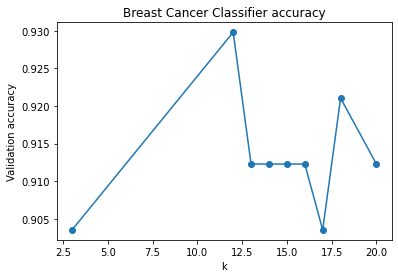

In [90]:
k_values = pd.DataFrame.from_dict({'K':k_list, 'accuracy':accuracies}).sort_values('accuracy', ascending=False).head(9).sort_values('K', ascending=False)['K'].tolist()
res = []

for k in k_values:
    classifier = KNeighborsClassifier(n_neighbors = k)
    classifier.fit(training_data, training_labels)

    res.append(classifier.score(validation_data, validation_labels))

plt.plot(k_values, res,marker='o')
plt.xlabel("k")
plt.ylabel("Validation accuracy")
plt.title("Breast Cancer Classifier accuracy")
plt.show()